In [3]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

# basicConfig(level=...) define qué tanta “verbosidad” quieres en los logs.
# getLogger() te da el objeto para escribir logs de manera profesional 
# (mejor que print() porque puedes guardar en archivos, filtrar, dar formato, etc.).
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5001'  # Optional: e.g., 'http://localhost:5555'

In [4]:
# Load dataset
data_path = '../data/processed/featured_house_data.csv'  # Update path if needed
data = pd.read_csv(data_path)
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

# Use XGBoost for RFE to stay consistent
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# RFE
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]


✅ Top 10 Selected Features by RFE:
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 9
 - 10
 - 13
 - 14

❌ Features Ignored by RFE:
 - 6
 - 7
 - 8
 - 11
 - 12
 - 15


In [6]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")


In [7]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}


In [8]:
# Encontrar el mejor modelo con GridSearch y evaluar
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


MLflow tracking URI: http://localhost:5001


In [ ]:
results = {}  
# Diccionario vacío donde se guardarán los resultados de cada modelo (métricas, parámetros, etc.)

with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():  
    # Si está configurado MLflow, inicia un experimento principal llamado "model_comparison".
    # Si no hay URI de tracking, usa nullcontext() (básicamente no hace nada).
    
    for name, model in models.items():  
        # Itera sobre todos los modelos definidos en el diccionario `models`.

        logger.info(f"Training {name}...")  
        # Escribe en el log qué modelo se está entrenando.

        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():  
            # Si MLflow está habilitado, abre un "run" anidado para este modelo en particular.
            # Esto permite llevar un seguimiento separado de cada modelo dentro del experimento principal.

            evaluation = evaluate_model_with_gridsearch(
                name, model, model_grids[name], X_train, y_train, X_test, y_test
            )  
            # Llama a una función que entrena y evalúa el modelo con GridSearchCV
            # usando los parámetros definidos en `model_grids` y los datos de entrenamiento/prueba.

            results[name] = evaluation  
            # Guarda el resultado de la evaluación en el diccionario `results`.

            if mlflow_tracking_uri:  
                # Si se está usando MLflow, registra los parámetros, métricas y el modelo entrenado.

                mlflow.log_params(evaluation['params'])  
                # Guarda los hiperparámetros usados por el modelo.

                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })  
                # Registra métricas de desempeño del modelo: error absoluto medio, error cuadrático, RMSE y R².

                mlflow.sklearn.log_model(
                    evaluation['model'], artifact_path=name.lower().replace(" ", "_")
                )  
                # Guarda el modelo entrenado como un artefacto en MLflow, con un nombre basado en el modelo.

            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")  
            # Imprime en consola el R² y RMSE del modelo entrenado, para tener feedback inmediato.


INFO:root:Training LinearRegression...
d:\Cursos\AI - Data Science\MLOps\Proyectos\house-price-predictor\house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/09/12 18:23:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training RandomForest...


LinearRegression R2: 0.9762, RMSE: 33266.50


d:\Cursos\AI - Data Science\MLOps\Proyectos\house-price-predictor\house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/09/12 18:23:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training GradientBoosting...


RandomForest R2: 0.9819, RMSE: 29059.86


d:\Cursos\AI - Data Science\MLOps\Proyectos\house-price-predictor\house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/09/12 18:23:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training XGBoost...


GradientBoosting R2: 0.9961, RMSE: 13404.00


d:\Cursos\AI - Data Science\MLOps\Proyectos\house-price-predictor\house-price-predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/09/12 18:23:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


XGBoost R2: 0.9787, RMSE: 31513.20


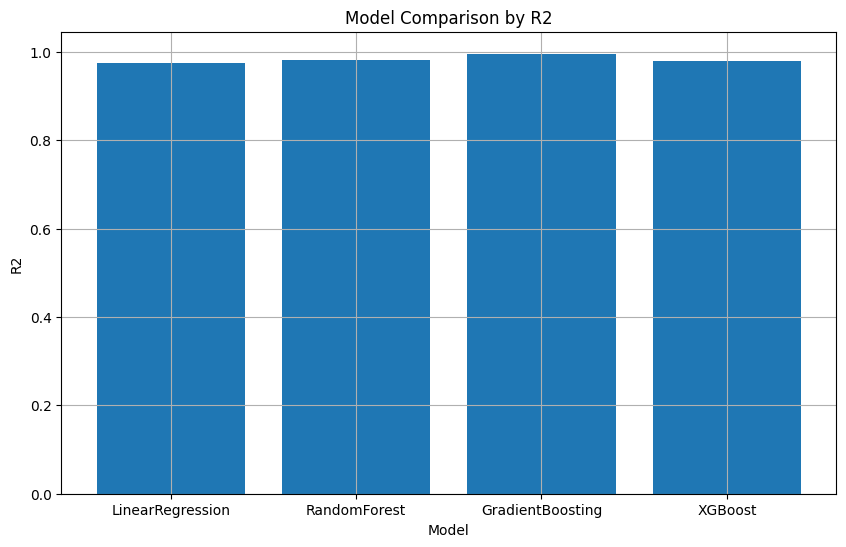

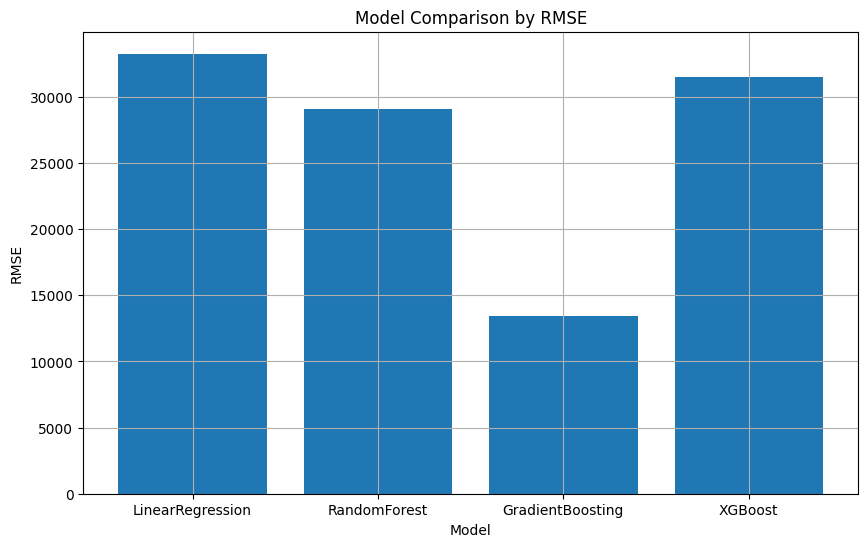

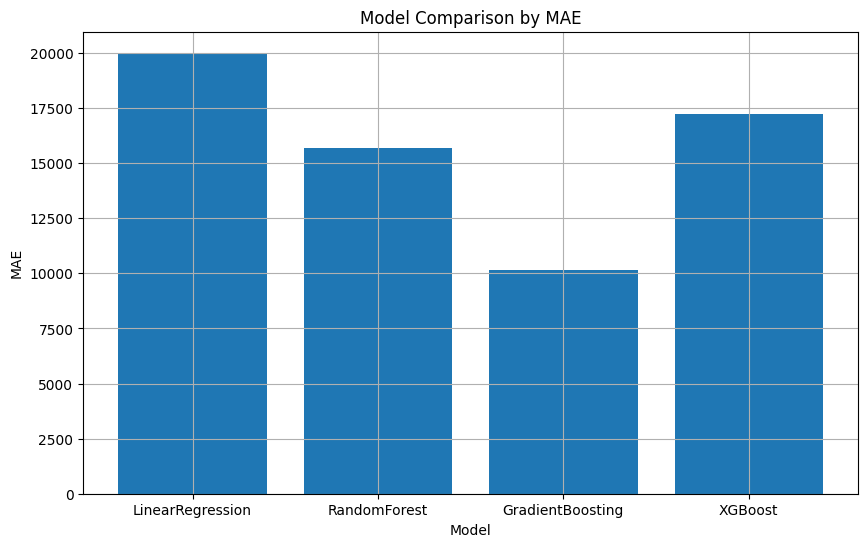

In [10]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')



In [ ]:
import yaml  
# Se importa la librería `yaml` para poder guardar la configuración del modelo en formato YAML.

# Save model config with selected features 
# Display information about the best model

best_model_name = max(results, key=lambda x: results[x]['r2'])  
# Encuentra el modelo con mejor puntaje R² dentro de `results`.
# Usa `max` con una función lambda que selecciona el valor de 'r2' como criterio.

best_model = results[best_model_name]['model']  
# Obtiene el objeto del mejor modelo (ya entrenado).

best_params = best_model.get_params()  
# Extrae los hiperparámetros del mejor modelo.

best_r2 = float(results[best_model_name]['r2'])  
best_mae = float(results[best_model_name]['mae'])  
best_rmse = float(results[best_model_name]['rmse'])  
# Convierte a float las métricas principales del mejor modelo:
# R², MAE y RMSE (para asegurar que sean serializables).

print(f"🏆 Best Model: {best_model_name}")  
print(f"   R² Score: {best_r2:.4f}")  
print(f"   MAE: {best_mae:.2f}")  
print(f"   RMSE: {best_rmse:.2f}")  
# Muestra en consola el nombre y métricas del mejor modelo.

model_config = {
    'model': {
        'name': 'house_price_model',              # Nombre general del modelo del proyecto
        'best_model': best_model_name,            # Algoritmo seleccionado como mejor
        'parameters': best_params,                # Hiperparámetros del mejor modelo
        'r2_score': best_r2,                      # Métrica R² del modelo
        'mae': best_mae,                          # Error absoluto medio
        'target_variable': 'price',               # Variable objetivo del dataset
        'feature_sets': selected_features_dict    # Conjunto de features usadas en el entrenamiento
    }
}
# Diccionario que guarda toda la configuración y métricas relevantes para poder reproducir el modelo.

config_path = '../configs/model_config.yaml'  
# Define la ruta donde se guardará la configuración (fuera de la carpeta actual, en /configs).

os.makedirs(os.path.dirname(config_path), exist_ok=True)  
# Crea la carpeta `configs` si no existe, para evitar errores al guardar el archivo.

with open(config_path, 'w') as f:  
    yaml.dump(model_config, f)  
# Abre el archivo YAML en modo escritura y guarda `model_config` dentro.

print(f"Saved model config to {config_path}")  
# Mensaje de confirmación de que la configuración del modelo fue guardada con éxito.


🏆 Best Model: GradientBoosting
   R² Score: 0.9961
   MAE: 10147.95
   RMSE: 13404.00
Saved model config to ../configs/model_config.yaml
